In [168]:
import random
import math # cos() for Rastrigin
import copy # array-copying convenience
import sys	 # max float
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [169]:
df = pd.read_csv('dataIntel.csv')

In [170]:
df.head(10)

,Unnamed: 0,DATE,TIME,EPOCH,NODEID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE,x_coord,y_coord
0,0,2004-02-28,01:08:45.992524,22,1,19.1456,38.9401,45.08,2.68742,10,7
1,1,2004-02-28,01:08:45.992525,25,2,19.1456,38.8379,45.08,2.69964,37,73
2,2,2004-02-28,01:08:45.992526,58,3,19.0084,38.9401,43.24,2.69964,87,8
3,3,2004-02-28,01:08:45.992527,62,4,18.9986,38.9742,43.24,2.68742,8,96
4,4,2004-02-28,01:08:45.992528,21,5,19.5670,39.6878,121.44,2.67532,8,57
5,5,2004-02-28,01:08:45.992529,25,6,19.5376,39.7557,121.44,2.67532,37,54
6,6,2004-02-28,01:08:45.992530,58,7,19.4788,39.6878,121.44,2.66332,100,51
7,7,2004-02-28,01:08:45.992531,61,8,19.4494,39.7217,121.44,2.67532,68,41
8,8,2004-02-28,01:08:45.992532,23060,9,21.2036,40.7706,50.60,2.61639,12,58
9,9,2004-02-28,01:08:45.992533,32667,10,19.6944,48.5139,1.84,2.32910,77,3


In [171]:
for i in range(0,100):
    df['NODEID'][i] = i

df.head(10)

C:\Users\goyal\AppData\Local\Temp/ipykernel_14244/761928403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NODEID'][i] = i


,Unnamed: 0,DATE,TIME,EPOCH,NODEID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE,x_coord,y_coord
0,0,2004-02-28,01:08:45.992524,22,0,19.1456,38.9401,45.08,2.68742,10,7
1,1,2004-02-28,01:08:45.992525,25,1,19.1456,38.8379,45.08,2.69964,37,73
2,2,2004-02-28,01:08:45.992526,58,2,19.0084,38.9401,43.24,2.69964,87,8
3,3,2004-02-28,01:08:45.992527,62,3,18.9986,38.9742,43.24,2.68742,8,96
4,4,2004-02-28,01:08:45.992528,21,4,19.5670,39.6878,121.44,2.67532,8,57
5,5,2004-02-28,01:08:45.992529,25,5,19.5376,39.7557,121.44,2.67532,37,54
6,6,2004-02-28,01:08:45.992530,58,6,19.4788,39.6878,121.44,2.66332,100,51
7,7,2004-02-28,01:08:45.992531,61,7,19.4494,39.7217,121.44,2.67532,68,41
8,8,2004-02-28,01:08:45.992532,23060,8,21.2036,40.7706,50.60,2.61639,12,58
9,9,2004-02-28,01:08:45.992533,32667,9,19.6944,48.5139,1.84,2.32910,77,3


In [172]:
x = []
y = []
for i in range(len(df)):
    x.append(df['x_coord'][i])
    y.append(df['y_coord'][i])


In [173]:
# global variables
global xc,yc,A,xbs,ybs,NCH,L,Reg,efs,emp,dth,N,Eda,Eelc # global variables
xc = 50 # centroid x coordinate
yc = 50 # centroid y coordinate
A = 0.5
xbs = 0 # base station x coordinate
ybs = 0 # base station y coordinate
NCH = 10 # number of cluster heads
L = 4000 # packet size (4000 bit)
Reg = 100 # region size (100m*100m)
efs = 10 * pow(10,-12) # energy factor for free space enviornment (10pj/bit/m^2)
emp = 0.0013 * pow(10,-12) # energy factor for multi space environment
dth = 88 # threshold distance
N = 100 #number of nodes
Eda = 5 * pow(10,-9) #energy consumption per bit during the data aggregation operation (5nj/bit/signal)
Eelc = 50 * pow(10,-9) #  energy consumption during 1-bit transmission or reception (50nj/bit/signal)





In [174]:
# Node Class
class Node:

    # constructor
    def __init__(self,x,y,id):
        self.x = x
        self.y = y
        self.id = id
        self.ein = 0.5
        self.isDead = True if self.ein <= 0 else False  # isDead is True if energy is 0 or less
        self.On = self.findOn()
        self.isCH = 0
        self.ClusterNumber = -1
        self.isDirect = True if self.On == 1 else False
        self.CH1 = -1
        self.CH2 = -1
        self.CH3 = -1
        self.CH4 = -1
        self.CH5 = -1
        self.CH6 = -1
        self.CH7 = -1
        self.CH8 = -1
    
    def position(self):
        print(self.x,self.y)
    
    def dn2bs(self):   # node to base station distance
        return math.sqrt((self.x - xbs)**2 + (self.y - ybs)**2)
    
    def dn2n(self,xi,yi):  #node to particular node distance
        return math.sqrt((self.x - xi)**2 + (self.y - yi)**2)

    def dn2c(self):   # node to centroid distance
        return math.sqrt((self.x - xc)**2 + (self.y - yc)**2)

    # calculate On
    def findOn(self):
        Emean = 0.1
        Eres = 0
        if(self.dn2bs() < dth):
            Eres = self.ein - (L*Eelc + L*efs*self.dn2bs()**2)
        else:
            Eres = self.ein - (L*Eelc + L*emp*self.dn2bs()**4)
        
        if(Eres >= Emean and self.dn2bs() < dth):
            return 1
        else:
            return 0

    



In [175]:
Nodes = []
for i in range(0,100):
    obj = Node(x[i],y[i],i)
    Nodes.append(obj)

In [176]:
# Calculate Energies
def findResidualTotal(Nodes):  # Residual Energy of all nodes
    Eres = []
    print(type(Nodes))
    for i in range(0,len(Nodes)):
        Eres.append(Nodes[i].ein - (L*Eelc + L*efs*Nodes[i].dn2bs()**2))
    return Eres

def findResidual(Node):  # Residual Energy of a particular node
    Eres = Node.ein - (L*Eelc + L*efs*Node.dn2bs()**2)
    return Eres


def findETx(d):  # energy consumption for transmission
    if(d < dth):
        return L*Eelc + L*efs*d**2
    else:
        return L*Eelc + L*emp*d**4

def findERx(): # energy consumption for reception
    return L*Eelc








In [177]:
Eres = findResidual(Nodes[3])
Eres

0.4994288

In [178]:
# Number of Alive Nodes
def findAliveNodes(Nodes):
    count = 0
    for i in range(0,len(Nodes)):
        if(Nodes[i].On == 0 and Nodes[i].ein > 0):
            count += 1
    return count

In [179]:
Na = findAliveNodes(Nodes)
print(Na)

33


In [180]:
#   Count of Direct Nodes
def findDirectNodes(Nodes):
    count = 0
    for i in range(0,len(Nodes)):
        if(Nodes[i].On == 1):
            count += 1
    return count

In [181]:
ds = findDirectNodes(Nodes)
print(ds)

67


In [182]:
# Optimum Number of K
dbs = 50
Kopt = int((math.sqrt(Na/(2*math.pi)))*(math.sqrt(efs/emp))*(Reg/dbs**2)) # optimum number of Cluster Heads
Kopt  

8

In [183]:
Nc = int(Na/ Kopt) # optimum number of nodes in each cluster
Nc


4

In [184]:
# find x1
def findx1(Node):
    return findResidual(Node)/Node.ein

# dmax
def findDmax(Nodes):
    d =[]
    for i in range(0,Nc):
        d.append(Nodes[i].dn2c())
    return max(d)

dmax = findDmax(Nodes)

# find x2
def findX2(Node):
    return (dmax - Node.dn2c())/dmax

# find x2dash
def findX2dash(Node):
    return (Node.dn2c()-dmax)/Node.dn2c()





In [185]:
# FCH Function
dmax = findDmax(Nodes)
def findFCH(Nodes,dmax):
    FCH = []
    alpha = 0.8
    ans = 0
    for i in range(0,100):
        if(Nodes[i].isDirect == False):
            if(Nodes[i].dn2c() < dmax):
                ans = alpha*findx1(Nodes[i]) + (1-alpha)*findX2(Nodes[i])
                FCH.append(ans)
            elif(Nodes[i].dn2c() == dmax):
                ans = findx1(Nodes[i])
                FCH.append(ans)
            else:
                ans = alpha*findx1(Nodes[i]) + (1-alpha)*findX2dash(Nodes[i])
                FCH.append(ans)
        else:
            FCH.append(-1)
        
    return FCH


    

In [186]:
FCH = findFCH(Nodes,dmax)
print(FCH)



[-1, -1, -1, 0.9988576, -1, -1, 0.8383011063782272, -1, -1, -1, 0.8020709379216264, 0.8801986983161102, -1, 0.8775540633087218, -1, -1, 0.9150445120492653, -1, -1, -1, 0.8463577617290194, 0.9374088239144324, 0.8028442144494727, -1, -1, -1, -1, 0.8146684388541422, 0.8407766555511752, -1, 0.8769650330349845, 0.89901632, -1, -1, -1, -1, 0.8556716937178307, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.905798559379694, -1, 0.9150445120492653, -1, 0.9064132277340667, -1, 0.8291725202575378, -1, -1, -1, -1, -1, -1, 0.937486005323951, 0.8679705842071402, -1, -1, -1, -1, 0.8993648621009209, -1, -1, 0.8590363979430183, -1, -1, 0.8245921692409958, -1, 0.8481613010679742, 0.8035340904117767, -1, 0.875902883123951, -1, -1, 0.8062452633832865, -1, 0.8304570428128965, -1, -1, 0.8246619930842531, -1, -1, -1, 0.8256016174715288, -1, -1, 0.8512330772143748, 0.8594467014432547, -1, -1, -1, -1, 0.849063215269156]


In [187]:
C = copy.deepcopy(FCH)
FCH.sort(reverse=True)
FCH[0:8]
CH = FCH[0:8]  # Cluster Head Array
print(CH)


[0.9988576, 0.937486005323951, 0.9374088239144324, 0.9150445120492653, 0.9150445120492653, 0.9064132277340667, 0.905798559379694, 0.8993648621009209]


In [188]:
count = 0
for i in range(0,len(FCH)):
    if(FCH[i] == -1):
        count += 1
print(count)

67


In [189]:
a = Nodes[6].y
print(a)

51


In [190]:
df2 = df['NODEID']
df2 = pd.DataFrame(df2)

In [191]:
df2['x_coord'] = x
df2['y_coord'] = y
df2['FCH'] = C
# Check node is cluster head or not
df2['CH'] = df2['FCH'].apply(lambda x: 1 if x >= FCH[Kopt-1] else 0)
df2.head(50)
#dataClusterHeads  = df2.to_csv('ClusterHeads.csv')

,NODEID,x_coord,y_coord,FCH,CH
0,0,10,7,-1.000000,0
1,1,37,73,-1.000000,0
2,2,87,8,-1.000000,0
3,3,8,96,0.998858,1
4,4,8,57,-1.000000,0
5,5,37,54,-1.000000,0
6,6,100,51,0.838301,0
7,7,68,41,-1.000000,0
8,8,12,58,-1.000000,0
9,9,77,3,-1.000000,0


In [192]:
# Every Node to Cluster Head Distance
ClusterHeads = []
for i in range(0,100):
    if(df2['CH'][i]==1):
        ClusterHeads.append(Nodes[i])

for i in range(0,len(ClusterHeads)):
    print(ClusterHeads[i].id)








3
16
21
48
50
52
61
67


In [193]:
# Every Node to Every Cluster Head Distance

def findCD(Nodes,ClusterHeads):
    dist = [] # empty dictionary
    for i in range(0,len(ClusterHeads)):
        li = []
        for j in range(0,len(Nodes)):
            if(Nodes[j].isDirect == False):
                li.append(Nodes[j].dn2n(ClusterHeads[i].x,ClusterHeads[i].y))
        dist.append(li)
    return dist

In [194]:
def findCHDistance(Nodes,ClusterHeads):
    for i in range(0,100):
        if(Nodes[i].isDirect == False):
            Nodes[i].CH1 = Nodes[i].dn2n(ClusterHeads[0].x,ClusterHeads[0].y)
            Nodes[i].CH2 = Nodes[i].dn2n(ClusterHeads[1].x,ClusterHeads[1].y)
            Nodes[i].CH3 = Nodes[i].dn2n(ClusterHeads[2].x,ClusterHeads[2].y)
            Nodes[i].CH4 = Nodes[i].dn2n(ClusterHeads[3].x,ClusterHeads[3].y)
            Nodes[i].CH5 = Nodes[i].dn2n(ClusterHeads[4].x,ClusterHeads[4].y)
            Nodes[i].CH6 = Nodes[i].dn2n(ClusterHeads[5].x,ClusterHeads[5].y)
            Nodes[i].CH7 = Nodes[i].dn2n(ClusterHeads[6].x,ClusterHeads[6].y)
            Nodes[i].CH8 = Nodes[i].dn2n(ClusterHeads[7].x,ClusterHeads[7].y)
        

           

In [195]:
Nodes[3].CH4

-1

In [196]:
findCHDistance(Nodes,ClusterHeads)

In [197]:
Nodes[1].id

1

In [198]:
for i in range(0,100):
    print(Nodes[i].CH1)

#print(Nodes[3].isDirect)

-1
-1
-1
0.0
-1
-1
102.41581909060729
-1
-1
-1
81.09870529176159
91.92388155425118
-1
66.94027188471824
-1
-1
67.11929677819934
-1
-1
-1
105.39449701004318
69.6419413859206
82.0
-1
-1
-1
-1
9.055385138137417
104.31682510506155
-1
91.7877987534291
69.6419413859206
-1
-1
-1
-1
57.14017850864661
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
43.46262762420146
-1
67.11929677819934
-1
80.1311425102625
-1
85.15867542417507
-1
-1
-1
-1
-1
-1
66.37017402418047
90.37698822156003
-1
-1
-1
-1
81.41252974819048
-1
-1
93.5200513259055
-1
-1
95.33624704172071
-1
107.93516572461452
91.13725912051558
-1
52.773099207835045
-1
-1
92.91393867445294
-1
77.31752712031083
-1
-1
69.00724599634447
-1
-1
-1
77.1621668954417
-1
-1
99.29753269845128
78.33900688673555
-1
-1
-1
-1
34.0


In [199]:
Avail = [1 for i in range(0,100)]  # Available Nodes
for i in range(0,100):
    if(Nodes[i].isDirect == True):
        Avail[i] = -1


In [200]:
temp = {}
temp['CH1']= Nodes[3].CH1
temp['CH2']= Nodes[3].CH2
temp['CH3']= Nodes[3].CH3
temp['CH4']= Nodes[3].CH4
temp['CH5']= Nodes[3].CH5
temp['CH6']= Nodes[3].CH6
temp['CH7']= Nodes[3].CH7
temp['CH8']= Nodes[3].CH8
sorted_temp = dict(sorted(temp.items(), key=lambda item: item[1]))
sorted_temp

{'CH1': 0.0,
 'CH4': 43.46262762420146,
 'CH7': 66.37017402418047,
 'CH2': 67.11929677819934,
 'CH5': 67.11929677819934,
 'CH3': 69.6419413859206,
 'CH6': 80.1311425102625,
 'CH8': 81.41252974819048}

In [201]:
# Find Cluster Number for Every Node
def findClusterNumber(Nodes,ClusterHeads,Avail):
    ans = []
    k1 = k2 = k3 = k4 = k5 = k6 = k7 = 3  #Number of Nodes Counter for each Cluster
    k8 = 4
    for i in range(0,100):
        if(Nodes[i].isDirect == True):
            ans.append(-1)
        elif(Nodes[i] in ClusterHeads):
            ans.append(0)
        else:
            temp = {}
            temp['CH1']= Nodes[i].CH1
            temp['CH2']= Nodes[i].CH2
            temp['CH3']= Nodes[i].CH3
            temp['CH4']= Nodes[i].CH4
            temp['CH5']= Nodes[i].CH5
            temp['CH6']= Nodes[i].CH6
            temp['CH7']= Nodes[i].CH7
            temp['CH8']= Nodes[i].CH8
            sorted_temp = dict(sorted(temp.items(), key=lambda item: item[1]))
            keys = list(sorted_temp.keys())
            values = list(sorted_temp.values())
            j = 0
            while(j<8):
                if(values[j] != 0 and Avail[i] == 1):
                    if(keys[j] == 'CH1'):
                        if(k1 > 0):
                            ans.append(1)
                            Avail[i] = 0
                            k1 -= 1
                            break
                        else:
                            j += 1
                    elif(keys[j] == 'CH2'):
                        if(k2 > 0):
                            ans.append(2)
                            Avail[i] = 0
                            k2 -= 1
                            break
                        else:
                            j += 1
                    elif(keys[j] == 'CH3'):
                        if(k3 > 0):
                            ans.append(3)
                            Avail[i] = 0
                            k3 -= 1
                            break
                        else:
                            j += 1
                    elif(keys[j] == 'CH4'):
                        if(k4 > 0):
                            ans.append(4)
                            Avail[i] = 0
                            k4 -= 1
                            break
                        else:
                            j += 1
                    elif(keys[j] == 'CH5'):
                        if(k5 > 0):
                            ans.append(5)
                            Avail[i] = 0
                            k5 -= 1
                            break
                        else:
                            j += 1
                    elif(keys[j] == 'CH6'):
                        if(k6 > 0):
                            ans.append(6)
                            Avail[i] = 0
                            k6 -= 1
                            break
                        else:
                            j += 1
                    elif(keys[j] == 'CH7'):
                        if(k7 > 0):
                            ans.append(7)
                            Avail[i] = 0
                            k7 -= 1
                            break
                        else:
                            j += 1
                    elif(keys[j] == 'CH8'):
                        if(k8 > 0):
                            ans.append(8)
                            Avail[i] = 0
                            k8 -= 1
                            break
                        else:
                            j += 1
                  
                else:
                    j += 1


            
    return ans

                    

In [202]:
ClusterNum = findClusterNumber(Nodes,ClusterHeads,Avail)
print(ClusterNum)
print(len(ClusterNum))

[-1, -1, -1, 0, -1, -1, 8, -1, -1, -1, 2, 8, -1, 2, -1, -1, 0, -1, -1, -1, 8, 0, 2, -1, -1, -1, -1, 1, 8, -1, 6, 5, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, 0, -1, 5, -1, -1, -1, -1, -1, -1, 0, 6, -1, -1, -1, -1, 0, -1, -1, 6, -1, -1, 5, -1, 3, 7, -1, 4, -1, -1, 3, -1, 7, -1, -1, 4, -1, -1, -1, 7, -1, -1, 3, 1, -1, -1, -1, -1, 1]
100


In [203]:
df2['whichCH'] = ClusterNum
#df2.drop('ClusterNumber',axis = 1, inplace =  True)
df2[1:50]

,NODEID,x_coord,y_coord,FCH,CH,whichCH
1,1,37,73,-1.000000,0,-1
2,2,87,8,-1.000000,0,-1
3,3,8,96,0.998858,1,0
4,4,8,57,-1.000000,0,-1
5,5,37,54,-1.000000,0,-1
6,6,100,51,0.838301,0,8
7,7,68,41,-1.000000,0,-1
8,8,12,58,-1.000000,0,-1
9,9,77,3,-1.000000,0,-1
10,10,89,100,0.802071,0,2


In [204]:
df2.to_csv('ClusteredData2.csv')

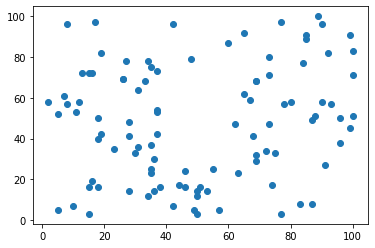

In [205]:
plt.scatter(df2['x_coord'],df2['y_coord'])
plt.show()

In [206]:
Cluster = copy.deepcopy(list(df2['whichCH']))
c = 1
for i in range(0,len(Cluster)):
    if(Cluster[i] == 0):
        Cluster[i] = c
        c += 1

df2['ClusterNumber'] = Cluster
df2[1:50]

,NODEID,x_coord,y_coord,FCH,CH,whichCH,ClusterNumber
1,1,37,73,-1.000000,0,-1,-1
2,2,87,8,-1.000000,0,-1,-1
3,3,8,96,0.998858,1,0,1
4,4,8,57,-1.000000,0,-1,-1
5,5,37,54,-1.000000,0,-1,-1
6,6,100,51,0.838301,0,8,8
7,7,68,41,-1.000000,0,-1,-1
8,8,12,58,-1.000000,0,-1,-1
9,9,77,3,-1.000000,0,-1,-1
10,10,89,100,0.802071,0,2,2


In [207]:
for i in range(0,100):
    Nodes[i].isCH = df2['CH'][i]
    Nodes[i].ClusterNumber = df2['ClusterNumber'][i] 

# Energy Loss During Transmission Phase

In [208]:
#In case of Direct Nodes
def findEnergyDirectNodes(Nodes):
    for i in range(0,100):
        if(Nodes[i].isDirect == True):
            d = Nodes[i].dn2bs()
            Nodes[i].ein = Nodes[i].ein - (findETx(d))


findEnergyDirectNodes(Nodes)



In [209]:
for i in range(0,10):
    print(Nodes[i].ein)

0.49979404
0.49953208
0.49949468
0.5
0.49966748
0.4996286
0.5
0.4995478
0.49965968
0.49956248


In [210]:
# In case of Non Direct Nodes
def findEnergyNonDirectNodes():
    for i in range(0,100):
        if(Nodes[i].isDirect == False):
            x = ClusterHeads[Nodes[i].ClusterNumber-1].x
            y = ClusterHeads[Nodes[i].ClusterNumber-1].y
            d = Nodes[i].dn2n(x,y)
            Nodes[i].ein = Nodes[i].ein - (findETx(d)) # Transmission Energy loss by Cluster Nodes during transmitting
            ClusterHeads[Nodes[i].ClusterNumber-1].ein = ClusterHeads[Nodes[i].ClusterNumber-1].ein - (findERx()) # Transmission Energy loss by Cluster Head during receiving the data
findEnergyNonDirectNodes()

In [211]:
for i in range(0,10):
    print(Nodes[i].ein)

0.49979404
0.49953208
0.49949468
0.4990000000000001
0.49966748
0.4996286
0.49978204
0.4995478
0.49965968
0.49956248


# Proposed Fitness Function Implementation

In [212]:
A = 0.5

# base station coordinates
x_bs = 0
y_bs = 0

def CH2BS(x_ch,y_ch):
    return math.sqrt((x_ch - xbs)**2 + (y_ch - ybs)**2)

def CH2C(x_ch,y_ch):
    return math.sqrt((x_ch - xc)**2 + (y_ch - yc)**2)

def dMax(CH):
    d_max = 0
    for i in range(len(CH)):
        d = CH2BS(CH[i].x,CH[i].y)
        if d > d_max:
            d_max = d
        
    return d_max + 1


def d2Max(CH):
    d_max = 0
    for i in range(len(CH)):
        d = CH2C(CH[i].x,CH[i].y)
        if d > d_max:
            d_max = d

    return d_max + 1

In [213]:
def findX1(obj):
    return obj.ein/0.5

def findX2(dmax,dCH2BS):
    return (dmax-dCH2BS)/dmax

def findX3(d2max,dCH2C):
    return (d2max-dCH2C)/d2max

def findCHtoNodes(ClusterHead,Nodes):
    obj = []
    clusterNumber = ClusterHead.ClusterNumber
    for i in range(len(Nodes)):
        if(Nodes[i].ClusterNumber == clusterNumber and Nodes[i].isCH == 0):
            obj.append(Nodes[i])
    return obj

def findX4(ClusterHead,Nodes):
    mini =  2147483647
    obj = findCHtoNodes(ClusterHead,Nodes)
    ans = 0
    for i in range(0,len(obj)):
        temp = obj[i].dn2n(ClusterHead.x,ClusterHead.y)
        if(temp < mini ):
            mini = temp
        ans = ans + temp
    
    return ans/mini

    



def findFO(A,x1,x2,x3,x4):
    return A*x1 + 0.4*A*x2 + (1-1.4*A)*x3 + 0.4*A*x4

In [214]:
for i in range(len(ClusterHeads)):
    print(ClusterHeads[i].ein)

0.4990000000000001
0.4990000000000001
0.4990000000000001
0.4990000000000001
0.4990000000000001
0.4990000000000001
0.4990000000000001
0.49880000000000013


In [215]:
gch = []  # Fitness Value Array for Finding Global Cluster Head
for i in range(0,len(ClusterHeads)):
    val = findFO(A,findX1(ClusterHeads[i]),findX2(dMax(ClusterHeads),CH2BS(ClusterHeads[i].x,ClusterHeads[i].y)),findX3(d2Max(ClusterHeads),CH2C(ClusterHeads[i].x,ClusterHeads[i].y)),findX4(ClusterHeads[i],Nodes))
    gch.append(val)


gch



[3.1918671449491742,
 2.030879843668513,
 1.461168134680648,
 1.6460900258498716,
 3.2036497791506906,
 1.3323746655852433,
 1.4036334150421728,
 2.078422379546102]

In [216]:
Global_CH = ClusterHeads[4] # Global Cluster Head


In [217]:
# Cluster Head to Cluster Head Communication
def findEnergyCH2CH(ClusterHeads):
    for i in range(0,len(ClusterHeads)):
        if(ClusterHeads[i] != Global_CH):
            d = ClusterHeads[i].dn2n(Global_CH.x,Global_CH.y)
            ClusterHeads[i].ein = ClusterHeads[i].ein - (findETx(d))
            Global_CH.ein = Global_CH.ein - (findERx())

findEnergyCH2CH(ClusterHeads)

In [218]:
# Global Cluster Head to Base Station Communication
d = Global_CH.dn2bs()
Global_CH.ein = Global_CH.ein - (findETx(d))

In [219]:
print(ClusterHeads[2].ein)
print(ClusterHeads[2].id)

0.4987966000000001
21


In [220]:
Global_CH.id

50

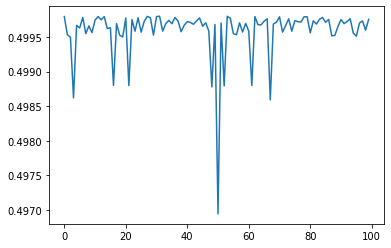

In [221]:
Energy = []
for i in range(0,len(Nodes)):
    Energy.append(Nodes[i].ein)

    
plt.plot(Energy)
plt.show()

In [222]:
Anomalies = [Nodes[25],Nodes[36],Nodes[38],Nodes[39],Nodes[80],Nodes[85],Nodes[92],Nodes[94]] # from Anomaly Detection

In [223]:
# Total Energy before Anomaly Detection
TotalEnergy = 0
for i in range(0,len(Nodes)):
    TotalEnergy = TotalEnergy + Nodes[i].ein

TotalEnergy

49.95891707323

In [224]:
# Total Energy after Anomaly Detection
TotalEnergy_Anomaly = 0
for i in range(0,len(Anomalies)):
    TotalEnergy_Anomaly = TotalEnergy_Anomaly + Anomalies[i].ein
TotalEnergy_Anomaly

3.9971416800000004

In [225]:
Final_Energy = TotalEnergy - TotalEnergy_Anomaly
Final_Energy

45.96177539323

In [226]:
Efficiency = (Final_Energy/TotalEnergy)*100
Efficiency

91.99914266728206

In [227]:
# # for 10000 rounds
# def NumberOfRounds(Nodes):
#     ResiudalEnergies = []
#     DeadNodes = []
#     NumberofCH = []
#     for i in range(0,10):
#         countDirectNodes = findDirectNodes(Nodes)
#         Na = findAliveNodes(Nodes)
#         kopt = int(findKopt(Na))
#         NumberofCH.append(kopt)
#         Nc = int(Na/kopt)
#         dmax = findDmax(Nodes)
#         FCH = findFCH(Nodes,dmax)
#         C = copy.deepcopy(FCH)
#         FCH.sort(reverse=True)
#         CH = [FCH[0:kopt]]  # Cluster Head Array
#         df3 = df['NODEID']




        

    

